## Loading the Dataset

In [1]:
import pandas as pd

# Load the dataset
file_path = 'store_data.csv'
df = pd.read_csv(file_path)

# Display the first few rows to inspect the dataset
df.head()


,date,store_no,region,city,postal,street,longitude,latitude,store_area,location_type,...,footfall,avg_temperature,min_temperature,max_temperature,precipitation_mm,snow_depth_mm,wind_direction_degrees,wind_speed_kmh,peak_wind_gust_kmh,air_pressure_hpa
0,2021-02-12,2335,Bayern,Lauf,91207,Marktplatz 15,11.281178,49.511979,449.0,Fußgängerzone,...,NaN,-10.9,-18.0,-2.8,0.0,130.0,79.0,14.2,35.3,1033.1
1,2021-03-01,197,Rheinland-pfalz,Bitburg,54634,Trierer Str.19,6.523312,49.970275,263.0,Hauptgeschaeftsstrasse,...,NaN,6.6,0.5,14.0,0.0,NaN,73.0,13.1,NaN,1032.6
2,2021-03-01,441,Rheinland-pfalz,Annweiler,76855,Hauptstr. 35,7.963420,49.202622,350.0,Hauptgeschaeftsstrasse,...,NaN,7.4,2.4,12.8,0.0,0.0,45.0,12.5,NaN,1032.5
3,2021-03-01,632,Saarland,Lebach,66822,Am Markt 6,6.906569,49.411052,363.0,Fußgängerzone,...,3.0,5.8,0.6,12.1,0.0,0.0,74.0,13.9,41.4,1032.0
4,2021-03-01,1218,Rheinland-pfalz,Traben-Trarbach,56841,Poststr. 1 A,7.116635,49.950358,354.0,Hauptgeschaeftsstrasse,...,3.0,5.5,0.3,12.4,0.0,0.0,51.0,11.2,40.3,1033.0


## Handling Missing Values

In [ ]:
# Fill missing values in 'footfall' column using the median
df['footfall'] = df['footfall'].fillna(df['footfall'].median()) 

# Confirm that missing values are filled
print(f"Missing values in 'footfall': {df['footfall'].isnull().sum()}")


Missing values in 'footfall': 0


## Handling Outliers

In [3]:
# Handle outliers by capping extreme values at the 99th percentile
for column in ['footfall', 'turnover']:
    df[column] = df[column].clip(upper=df[column].quantile(0.99))

# Confirm changes
print(df[['footfall', 'turnover']].describe())


            footfall       turnover
count  414645.000000  414645.000000
mean       19.512721     134.545291
std         6.448615      53.635114
min         2.000000      -4.101720
25%        18.000000      97.487100
50%        19.000000     129.456120
75%        20.000000     165.893940
max        43.000000     302.593027


## Adding new features

In [4]:
# Add interaction feature: store_area * footfall
df['store_area_footfall'] = df['store_area'] * df['footfall']

# Add month as a new feature
df['month'] = pd.to_datetime(df['date']).dt.month

# Group low-frequency cities into an 'Other' category
top_cities = df['city'].value_counts().nlargest(50).index
df['city'] = df['city'].apply(lambda x: x if x in top_cities else 'Other')


##  Define Features and Target

In [5]:
# Updated feature set with new interaction terms
selected_features = [
    'store_area', 'footfall', 'avg_temperature', 'city', 
    'precipitation_mm', 'air_pressure_hpa', 'wind_speed_kmh',
    'store_area_footfall', 'month'
]
X = df[selected_features]
y = df['turnover']


## Preprocessing and Model Pipeline

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), [
            'store_area', 'footfall', 'avg_temperature', 'precipitation_mm',
            'air_pressure_hpa', 'wind_speed_kmh', 'store_area_footfall', 'month'
        ]),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ['city'])
    ]
)

# Define the XGBoost model
xgboost_model = xgb.XGBRegressor(random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost_model)
])


## Perform Hyperparameter Tuning

In [7]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 6, 9],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.7, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.9, 1.0],
}

# Perform randomized search
random_search = RandomizedSearchCV(
    pipeline, param_grid, n_iter=20, cv=3, scoring='r2', random_state=42, n_jobs=-1
)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)


c:\Users\amrit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\amrit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\amrit\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\amrit\AppData\

Best Parameters: {'model__subsample': 0.9, 'model__n_estimators': 500, 'model__min_child_weight': 1, 'model__max_depth': 9, 'model__learning_rate': 0.1, 'model__colsample_bytree': 1.0}


## Evaluate the Tuned Model

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions using the best estimator
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Tuned XGBoost Model Performance:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR² (Accuracy): {r2:.2f}")


Tuned XGBoost Model Performance:
MAE: 28.80
RMSE: 37.74
R² (Accuracy): 0.50


<Figure size 1000x600 with 0 Axes>

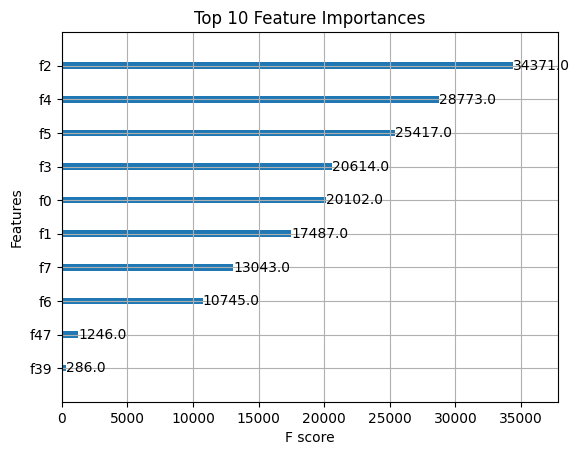

In [9]:
import matplotlib.pyplot as plt

# Extract the trained XGBoost model from the pipeline
model = best_model.named_steps['model']

# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()
